# grid world
This gridworld implementation works in conjunction with [openai gym](https://gym.openai.com/). The agent (smiley face) can move left, right, up, and down in arbitrary, user-defined mazes. A `nonterminal_reward` is emited at every time step until a terminal state is reached, at which point the agent gets a user-defined reward.

In [1]:
import gym
import rickgrid
from rickgrid.mazes import mazes
import numpy as np
import matplotlib.pyplot as plt
from rickgrid import Control

# define simple maze
np.random.seed(0)  # hashtag-reproducibility
env = gym.make('RickGrid-v0',
               walls = np.array([[0,0,1,0,0],
                                 [0,0,1,0,0],
                                 [0,0,1,0,0],
                                 [0,0,1,0,0],
                                 [0,0,0,0,0]], dtype='bool'),
               rewards = [[0,4,1]],
               start_coords = [0,0],
               nonterminal_reward=-1,
               random_start=False)

env.render(); # show maze
env.step(1);  # step to the right
env.render(); # show maze again




██████████████
██☺   ██   1██
██    ██    ██
██    ██    ██
██    ██    ██
██          ██
██████████████

██████████████
██  ☺ ██   1██
██    ██    ██
██    ██    ██
██    ██    ██
██          ██
██████████████


# algorithms
We can learn policies using action-value based tabular approaches, each of which actions $\epsilon$-greedy with respect to $\hat{q}(s,a)$.

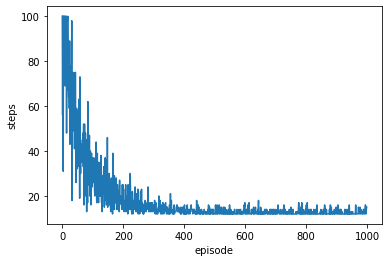

In [2]:
# set up Q Learning object
ctl_q = Control.QLearning(env)

# train, recording number of steps per episode
steps_q, rewards_q = ctl_q.train(alpha=.05, gamma=1, epsilon=.05, episodes=1000);

# plot steps per episode
ax = plt.axes(xlabel='episode', ylabel='steps')
ax.plot(steps_q);

The number of steps per episode has decreased. Nice. There should be a corresponding evolution in the value function. Let's see...

episode 1


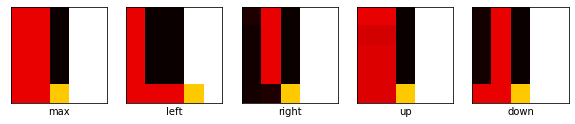

episode 2


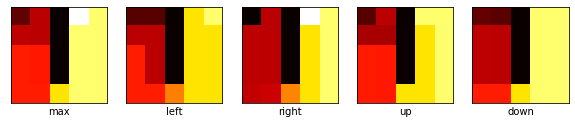

episode 3


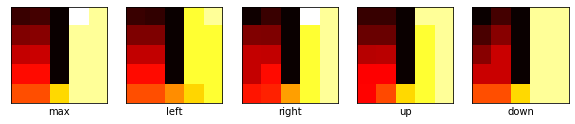

episode 4


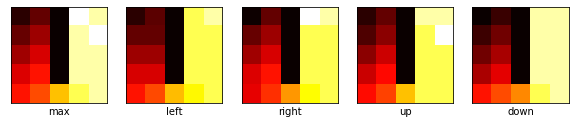

episode 5


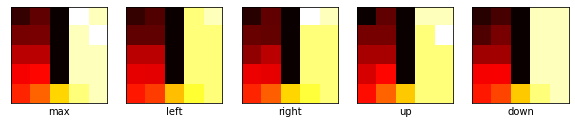

episode 6


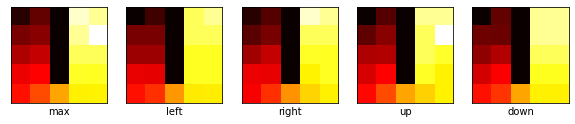

In [17]:
dt = 1
steps = 6

ctl_q.resetQ();  # reset Q to initial values

for i in np.arange(dt, dt*(steps+1), dt):
    print('episode {}'.format(i))
    steps_q, rewards_q = ctl_q.train(alpha=.05, gamma=1, epsilon=.05, episodes=dt);
    ctl_q.plotQ();
    
    

In [ ]:
env.reset()
env.render(Q=ctl_q.Q);

This seems non-crazy! Let's try Monte Carlo:

In [ ]:
# set up Monte Carlo object
ctl_mc = Control.MonteCarlo(env)
env.random_start = False

# train, recording number of steps per episode
steps_mc, rewards_mc = ctl_mc.train(alpha=.05, gamma=1, epsilon=.05, episodes=1000);

# show policy
env.reset()
env.render(Q=ctl_mc.Q);

# plot steps per episode
ax = plt.axes(xlabel='episode', ylabel='steps')
ax.plot(steps_mc);

What a goofy learning curve. There seems to be an 'aha' moment at ~200 episodes. The agent has to 'accidentally' discover the terminal location at least once before learning can really occur. This could be a major challenge, especially if the path to the reward were longer than it is.